In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [133]:
def make_df(fnames, 
    old_frame=None, 
    reward_ahead=10, 
    timestep_gap=1, 
    prev_act_window=3, 
    jump_limit=100,
    ):

    '''
    Takes a file and turns it into a trajectory dataframe.
    Can add to old data.
    Inputs:
                old_frame: old df
             reward_ahead: how many steps ahead to sum reward, for each table entry
             timestep_gap: how data are sampled (e.g. =5 means only every fifth datapoint is kept)
          prev_act_window: how many steps to look back to make sure all actions were 'on' or 'off'
               jump_limit: data are processed to remove faulty points where worm loc has jumped really far.
                           This is the maximum jump distance allowed before points are tossed.
                     disc: discretization of angles

    Output:
        dataframe object with keys:
            't', 'obs_b', 'obs_h', 'prev_actions', 'next_obs_b', 'next_obs_h', 'reward', 'loc'
    '''
    def add_ind_to_df(traj,df,i, reward_ahead, prev_act_window):
        # Assumes data for angle observations go from -1 to 1. (not sure why)
        ANG_BOUND = 180
        return df.append({
            't'           : traj['t'][i],
            'obs_b'       : int(traj['obs'][i][0]*ANG_BOUND),
            'obs_h'       : int(traj['obs'][i][1]*ANG_BOUND),
            'prev_actions': sum(traj['action'][i-prev_act_window:i]), # Note does not include current action
            'next_obs_b'  : int(traj['obs'][i+1][0]*ANG_BOUND),
            'next_obs_h'  : int(traj['obs'][i+1][1]*ANG_BOUND),
            'reward'      : sum(traj['reward'][i:i+reward_ahead]),
            'loc'         : traj['loc'][i],
        }, ignore_index=True)

    if old_frame is None:
        df = pd.DataFrame(columns = ['t', 
            'obs_b', 'obs_h', 'prev_actions', 
            'next_obs_b', 'next_obs_h', 'reward', 'loc'])
    else:
        df = old_frame

    # For every file, loop through and remove problem points.
    for fname in fnames:
        newf = True
        with open(fname, 'rb') as f:
            traj = pickle.load(f)

        for i in np.arange(prev_act_window,len(traj['t'])-reward_ahead,timestep_gap):
            # For every timestep, check if the jump is reasonable and add to dataframe.
            if newf:
                if sum(traj['loc'][i])!=0:
                    df = add_ind_to_df(traj,df,i,reward_ahead,prev_act_window)
                    newf = False
            elif np.sqrt(np.sum(np.square(df['loc'].iloc[-1]-traj['loc'][i]))) < jump_limit:
                df = add_ind_to_df(traj,df,i,reward_ahead,prev_act_window)

    return df

In [138]:
fnames=[
    # First worm
#     'Data/traj12-11-2020_19-04-41.pkl', #none
     'Data/traj12-11-2020_19-14-38.pkl', #none
#     'Data/traj12-11-2020_19-24-30.pkl', #xlim 800
#     'Data/traj12-11-2020_19-35-31.pkl', #none # Seems like an especially bad dataset. Actually ruined all the others

#     # Second worm
#     'Data/traj12-11-2020_19-55-19.pkl', #none
#     'Data/traj12-11-2020_20-05-11.pkl', #none
#     'Data/traj12-11-2020_20-15-17.pkl', #none
#     'Data/traj12-11-2020_20-25-06.pkl', #xlim 1430

#     # Third worm
#     'Data/traj30-10-2020_18-14-00.pkl', #none
#     'Data/traj30-10-2020_18-34-10.pkl', #none

#     # Fourth worm
#     'Data/traj02-11-2020_15-53-56.pkl', #none 
#     'Data/traj02-11-2020_16-14-45.pkl', #none 

#     # Fifth worm
#     'Data/traj03-11-2020_14-46-45.pkl', #none
#     'Data/traj03-11-2020_15-08-07.pkl', #none
]

traj_df = make_df(fnames, 
    old_frame=None, 
    reward_ahead=30, 
    timestep_gap=10, 
    prev_act_window=20, 
    jump_limit=100,
    )

In [78]:
#traj_df.to_pickle('./all_traj_df.pkl')

In [139]:
traj_df['prev_actions']

0       5
1       5
2      15
3      10
4       5
       ..
240    10
241    15
242    20
243    15
244     5
Name: prev_actions, Length: 245, dtype: object

In [81]:
locs = np.zeros((len(traj_df),2))
for i in range(locs.shape[0]):
    locs[i,:] = traj_df['loc'][i]

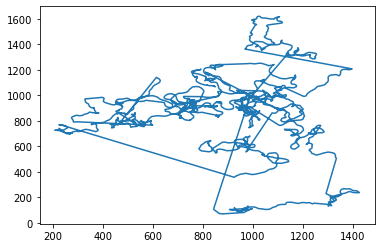

In [82]:
plt.plot(locs[:,0],locs[:,1])

In [111]:
traj_df.loc[traj_df['reward']>0,'reward'] = traj_df.loc[traj_df]

In [114]:
traj_df[traj_df['reward']>0]['reward'] = np.zeros(len(traj_df[traj_df['reward']>0]['reward']))

In [142]:
traj_df[traj_df['reward']>0]['reward']

0       7.755952
1       8.750187
2       8.215190
3      11.022556
4       9.831431
         ...    
240    21.503354
241    17.190476
242     9.406530
243     7.204719
244     4.727473
Name: reward, Length: 127, dtype: float64

In [151]:
traj_df.loc[traj_df['reward']==0,'reward'] = traj_df[traj_df['reward']==0]+2

In [152]:
sum(traj_df['reward'])

-1120.3930101889846